## Analyze A/B Test Results

The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. 

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusions)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Load and understand our data set charactaristic

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
T1=df.query("group != 'treatment' and landing_page == 'new_page'")['user_id'].count()

In [7]:
T2=df.query("group == 'treatment' and landing_page != 'new_page'")['user_id'].count()

In [8]:
c1=df.query("group != 'control' and landing_page == 'old_page'")['user_id'].count()

In [9]:
c2=df.query("group == 'control' and landing_page != 'old_page'")['user_id'].count()

In [10]:
T1+T2

3893

In [11]:
c1+c2

3893

f. Do any of the rows have missing values?

In [12]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Store the new dataframe as **df2**.

In [13]:
df_t=df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]

In [14]:
df_c=df[((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]

In [15]:
df2=pd.concat([df_t,df_c])

In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Working with **df2** 

a. How many unique **user_id**s are in **df2**?

In [17]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [18]:
df2[df2.user_id.duplicated(keep=False)].user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [19]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [20]:
df2.drop_duplicates(subset=['user_id'], inplace=True)
df2.shape[0]==df2.user_id.nunique()

True

In [21]:
df2.group.value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [22]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [25]:
df2.query('landing_page == "new_page"')['user_id'].count()/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Considering this sample result, the statistic of the propability of conversion is almost same for both groups.** 
**We need to draw a sample distribution by bootstarapping to check if this  hypothesis is statisticaly  significient or not.**

<a id='ab_test'></a>
### Part II - A/B Test

As the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we consider the decision is just based on all the data provided.  we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- **H0:  𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 = 0**
- **H1:  𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 != 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [26]:
pn=df2.converted.mean()

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [27]:
po=df2.converted.mean()

c. What is $n_{new}$, the number of individuals in the treatment group?

In [28]:
n_new=df2[df2['group'] == 'treatment']['user_id'].count()

d. What is $n_{old}$, the number of individuals in the control group?

In [29]:
n_old=df2[df2['group'] == 'control']['user_id'].count()

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [61]:
new_page_coverted= np.random.binomial(1,pn,n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [62]:
old_page_coverted= np.random.binomial(1,po,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [63]:
obs=new_page_coverted.mean()-old_page_coverted.mean()
obs

0.0022075312601751718

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [64]:
p_diffs=[]
for _ in range(10000):
    sample=df2.sample(len(df2),replace=True)
    p=df2.converted.mean()
    n_new=sample[sample['group'] == 'treatment']['user_id'].count()
    n_old=sample[sample['group'] == 'control']['user_id'].count()
    new_page_coverted= np.random.binomial(1,p,n_new)
    old_page_coverted= np.random.binomial(1,p,n_old)
    p_diffs.append(new_page_coverted.mean()-old_page_coverted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

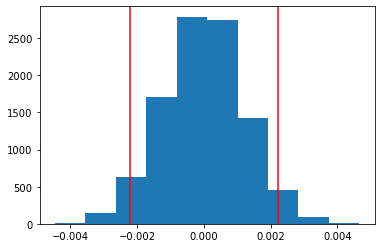

In [65]:
p_diffs=np.array(p_diffs)
null=np.random.normal(0,p_diffs.std(),p_diffs.size)
plt.hist(null);
plt.axvline(x=obs, c="red")
plt.axvline(x=-obs, c="red");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [66]:
(obs<null).mean()+((-obs)>null).mean()

0.0668

k. What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We Fail to reject The null hypothesis. This indicates that there is no statistical signifecance difference on convertion rate between the new page and old page**

l. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest as smz

convert_old = df2[df2['group'] == 'control']['converted'].sum() 
convert_new = df2[df2['group'] == 'treatment']['converted'].sum()
n_old = df2[df2['group'] == 'control']['user_id'].count()
n_new = df2[df2['group'] == 'treatment']['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [67]:
count = np.array([convert_old, convert_new])
nos = np.array([n_old, n_new])
z_score,alpha = sm.stats.proportions_ztest(count, nos, alternative = 'smaller')
z_score,alpha

(1.4599775708009035, 0.9278518808407223)

In [41]:
np.percentile(null, 2.5), np.percentile(null, 97.5) 

(-0.002274838434513606, 0.0023452769707651474)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**We Fail to reject The null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will compare that the result in the A/B test in Part II above to regression approach.<br><br> 

a. Since each row is either a conversion or no conversion, which approach is better?

**The output of our data set is categorical binary.so, We should use Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
df2['intercipt']=1
df2[['dum','ab_page']]=pd.get_dummies(df2['group'])
df2.drop(['dum'], axis=1, inplace=True)
df2.sample(5)

,user_id,timestamp,group,landing_page,converted,intercipt,ab_page
40835,855680,2017-01-02 18:25:32.786471,control,old_page,0,1,0
284576,919585,2017-01-10 21:11:43.913299,treatment,new_page,1,1,1
145461,849452,2017-01-23 13:49:58.733050,control,old_page,0,1,0
293306,819901,2017-01-15 18:33:33.080410,control,old_page,1,1,0
23815,921140,2017-01-22 02:12:47.683330,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [43]:
X= df2[['intercipt','ab_page']]
Y= df2['converted']
log_reg = sm.Logit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [44]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Aug 2021   Pseudo R-squ.:               8.077e-06
Time:                        07:13:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercipt     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Based on this results, P-value (0.19) exceeds alpha. We can conclude that the type of page is not statisticaly significent.**

**We fail to reject the null hypothesis.**

**The difference between p-values of Part 2 and 3 is that we have performed a one-tailed test in Part 2, and in Part 3, we are performing a two-tailed test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The economic status and income level of the customers can have a direct influence of this decision to covert to pay for this service**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **we will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [46]:
df_cont= pd.read_csv('countries.csv')
df3=df2.join(df_cont.set_index('user_id'), on='user_id')
df3.shape[0] == df2.shape[0]
df3.sample(5)

,user_id,timestamp,group,landing_page,converted,intercipt,ab_page,country
11648,664605,2017-01-23 22:51:41.488958,treatment,new_page,0,1,1,UK
168950,758311,2017-01-13 00:35:16.645006,treatment,new_page,0,1,1,US
16408,767229,2017-01-17 20:29:05.095279,treatment,new_page,0,1,1,UK
258789,933032,2017-01-13 20:06:18.982678,treatment,new_page,0,1,1,US
148693,813214,2017-01-16 20:34:11.236351,treatment,new_page,0,1,1,US


In [47]:
df3[['UK','US', 'CA']]= pd.get_dummies(df3['country'])
X= df3[['intercipt','UK','US']]
y= df3['converted']
log_reg2= sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 


In [48]:
print(log_reg2.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 06 Aug 2021   Pseudo R-squ.:               1.521e-05
Time:                        07:15:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercipt     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
US             0.0099      0.013      0.746      0.4

**Based in this results, P-value exceeds alpha.** 

**larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.**

***The Country of users is not statisticaly significent.***

<a id='conclusions'></a>
## Conclusion

> **The company should stick to the old page as the new page appears to have the same impact as the old one according to A/B  testing method and Logistic regression modeling approach**


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])